In [5]:
from tqdm import tqdm
import time
import argparse
import os
from abc import abstractmethod
from torch.nn import functional as F
import random 

import pandas as pd
import numpy as np

import torch
from torch import nn
import torch.nn.init as init
from torchvision import datasets
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from PIL import Image

In [27]:
parser = argparse.ArgumentParser(description = "")
parser.add_argument("--dataset", default="CANDLE", type=str, help="The dataset used for training.")
parser.add_argument("--data-path", default= "/cmlscratch/margot98/Causal_Disentangle/CANDLE_dataset/images/", type=str,
                    help="The path to the folder stroing the data.")
parser.add_argument("--attr-path", default= "/cmlscratch/margot98/Causal_Disentangle/CANDLE_dataset/CANDLE_label_test.txt", type=str,
                    help="The path to the folder stroing the attribute of the data.")
parser.add_argument("--batch-size", type=int, default=128, metavar='B',
                    help="input batch size for training (default: 128)")

args = parser.parse_args(args=[])


class entangled_Candle(Dataset):
    """Load entangled dataset for training"""
    def __init__(self, data_path, attr_path,ratio, attr = [], transform=None):
        df = pd.read_csv(attr_path, sep=" ", index_col=0)
        df = df.replace(-1, 0)
        self.data_path = data_path
        self.attr_path = attr_path
        self.entangled_names, self.disentangled_names,self.img_names = self.entangled(attr_path,ratio)
        self.target = df[attr].values if attr else df.values
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(os.path.join(self.data_path,str(self.img_names[index])+'.png'))
        
        if self.transform is not None:
            img = self.transform(img)
            img = img[:3, :, :]
        
        label = self.target[index]
        return img, label
    
    def __len__(self):
        return len(self.img_names)
    
    def entangled(self,attr_path,ratio):
        df = pd.read_csv(attr_path, sep=" ", index_col=0)
        df = df.replace(-1, 0)
        all_img_names = df.index.values
        target = df.values

        entangled_img = []
        all_disentangled_img = []
        disentangled_img = []
        for i, name in enumerate(all_img_names):
            if target[i,0] == target[i,2]:
                entangled_img.append(name)
            else:
                all_disentangled_img.append(name)

        dis_num = round(len(entangled_img)/ratio) - len(entangled_img)
        disentangled_img = random.sample(all_disentangled_img, dis_num)
        all_imgs = entangled_img + disentangled_img

        return entangled_img, disentangled_img, all_imgs

    
class CandleDataset(Dataset):
    """Custom Dataset for loading CANDLE generated images"""

    def __init__(self, data_path, attr_path, attr=[], transform=None):
    
        df = pd.read_csv(attr_path, sep=" ", index_col=0)
        df = df.replace(-1, 0)
        self.data_path = data_path
        self.attr_path = attr_path
        self.img_names = df.index.values
        self.target = df[attr].values if attr else df.values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.data_path,str(self.img_names[index])+'.png'))
        
        if self.transform is not None:
            img = self.transform(img)
            img = img[:3, :, :]
        
        label = self.target[index]
        return img, label

    def __len__(self):
        return self.target.shape[0]

image_size = 64
transform = T.Compose([
    T.Resize([image_size, image_size]),
    T.ToTensor()
])

# train_dataset = CandleDataset(data_path="/cmlscratch/margot98/Causal_Disentangle/CANDLE_dataset/images",
#                               attr_path='CANDLE_label_test.txt',
#                               attr=['cube','sphere'],
#                               transform=transform)

train_dataset = entangled_Candle(data_path="/cmlscratch/margot98/Causal_Disentangle/CANDLE_dataset/images",
                              attr_path='CANDLE_label_test.txt',
                            ratio = 0.7,
                              attr=['cube','sphere'],
                              transform=transform)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=args.batch_size,
                          shuffle=True,
                          num_workers=4) 

In [28]:
class BaseVAE(nn.Module):
    def __init__(self):
        super(BaseVAE, self).__init__()

    def encode(self, x):
        """
        Encodes the inputs by passing through the encoder
        :param x: (Tensor) Input tensor to encoder [B x C x H x W]
        :return: (Tensor) Mean and Log Variance vector of the Multi-Gaussian.
        """
        raise NotImplementedError

    def decode(self, z):
        """
        Maps the given latent representations to images
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        raise NotImplementedError

    def generate(self, num_samples, current_device=None, **kwargs):
        """
        Samples [num_samples] latent vectors and maps them to images
        :param num_samples: (int) N number of samples to generate
        :param current_device: (int) device number, usually represented by variable device
        :return: (Tensor, Tensor) [N x C x H x W]
        
        """
        raise NotImplementedError


    @abstractmethod
    def forward(self, *inputs):
        pass


class VAE(BaseVAE):
    """
     vanilla VAE
     
    """
    def __init__(self,
                 z_dim,
                 in_channels=3
                ):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        
        # Encoder
        
        self.encoder = nn.Sequential(
            # B,  32, 32, 32
            nn.Conv2d(in_channels, out_channels=32, kernel_size=4, stride=2, padding=1),          
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # B,  32, 16, 16
            nn.Conv2d(32, out_channels=32, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # B,  64,  8,  8
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # B,  64,  4,  4
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),          
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # B, 256,  1,  1
            nn.Conv2d(64, 256, kernel_size=4, stride=1),           
            nn.BatchNorm2d(256),
            nn.ReLU(),
            View((-1, 256*1*1)),                 # B, 256
            
            # for mu and logvar
            nn.Linear(256, z_dim*2),             # B, z_dim*2
        )
        
        # Decoder
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),               # B, 256
            View((-1, 256, 1, 1)),               # B, 256,  1,  1
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, 4),      # B,  64,  4,  4
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 4, 2, 1), # B,  64,  8,  8
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), # B,  32, 16, 16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, 4, 2, 1), # B,  32, 32, 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, in_channels, 4, 2, 1),  # B, 3, 64, 64
        )

        self.weight_init()
        
    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)
                
    def encode(self, x):
        """
        Encodes the inputs by passing through the encoder
        :param x: (Tensor) Input tensor to encoder [B x C x H x W]
        :param z_dim: (int) dimension of the latent representation
        :return: (Tensor, Tensor) Mean and Log Variance vector of the Multi-Gaussian. [B x D]
        
        2D: D dimensional mu and D dimensional logvar
        """
        result = self.encoder(x) # B x 2D
        mu = result[:, :self.z_dim]
        logvar = result[:, self.z_dim:]
        return mu, logvar
    
    def decode(self, z):
        """
        Maps the given latent representations to images
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        return self.decoder(z)
    
    
    def generate(self, num_samples, current_device=None):
        """
        Samples [num_samples] latent vectors and maps them to images
        :param num_samples: (int) N number of samples to generate
        :param current_device: (int) device number, usually represented by variable device
        :return: (Tensor, Tensor) [N x C x H x W]
        
        """
        z = torch.randn(num_samples, self.z_dim)
        if current_device:
            z = z.to(current_device)
        samples = self.decode(z)
        return samples
        
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = reparametrize(mu, logvar)
        reconstructed_z = self.decode(z)
        return reconstructed_z, mu, logvar
    

In [9]:
class View(nn.Module):
    def __init__(self, size):
        super(View, self).__init__()
        self.size = size

    def forward(self, tensor):
        return tensor.view(self.size)

def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.weight.data.normal_(mean, std)
        if m.bias.data is not None:
            m.bias.data.zero_()
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.fill_(1)
        if m.bias.data is not None:
            m.bias.data.zero_()

In [10]:
def reparametrize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return eps * std + mu

In [11]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
model = VAE(z_dim=128)

In [31]:
args.train_samples = len(train_loader) * 128
args.learning_rate = 0.01*float(128)/256.
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, 
                            momentum=0.9, weight_decay=5e-4)

In [33]:
for epoch in tqdm(range(5)):
    model.train()
    i = 0
    for input, target in train_loader:
        i += 1
        batch_time = AverageMeter()
        losses = AverageMeter()
        end = time.time()
        total_start = time.time()
        
        output = model(input)
        recons_loss = F.mse_loss(output[0], input)
        mu = output[1]
        log_var = output[2]
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        kld_weight = input.shape[0] / args.train_samples
        
        loss = recons_loss + kld_loss * kld_weight

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%15 == 0:
        
            reduced_loss = loss.data
            losses.update(float(reduced_loss), input.size(0))
            # torch.cuda.synchronize()
            batch_time.update((time.time() - end)/15)
            end = time.time()

            print('Epoch: [{0}][{1}/{2}]\t'
                          'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                          'Loss {loss.val:.5f} ({loss.avg:.4f})\t'.format(
                           epoch, i, len(train_loader),
                           batch_time=batch_time,
                           loss=losses))
        

  0%|                                                                                | 0/5 [00:00<?, ?it/s]

Epoch: [0][15/35]	Time 0.068 (0.068)	Loss 0.19624 (0.1962)	
Epoch: [0][30/35]	Time 0.040 (0.040)	Loss 0.14096 (0.1410)	


 20%|██████████████▍                                                         | 1/5 [00:48<03:14, 48.55s/it]

Epoch: [1][15/35]	Time 0.155 (0.155)	Loss 0.11921 (0.1192)	
Epoch: [1][30/35]	Time 0.028 (0.028)	Loss 0.09743 (0.0974)	


 40%|████████████████████████████▊                                           | 2/5 [01:40<02:31, 50.39s/it]

Epoch: [2][15/35]	Time 0.117 (0.117)	Loss 0.08709 (0.0871)	
Epoch: [2][30/35]	Time 0.031 (0.031)	Loss 0.08691 (0.0869)	


 60%|███████████████████████████████████████████▏                            | 3/5 [02:31<01:41, 50.82s/it]

Epoch: [3][15/35]	Time 0.132 (0.132)	Loss 0.07517 (0.0752)	
Epoch: [3][30/35]	Time 0.026 (0.026)	Loss 0.07007 (0.0701)	


 80%|█████████████████████████████████████████████████████████▌              | 4/5 [03:26<00:52, 52.33s/it]

Epoch: [4][15/35]	Time 0.113 (0.113)	Loss 0.06683 (0.0668)	
Epoch: [4][30/35]	Time 0.035 (0.035)	Loss 0.06602 (0.0660)	


100%|████████████████████████████████████████████████████████████████████████| 5/5 [04:20<00:00, 52.07s/it]


In [34]:
# convert ddp stat_dic to normal stat_dict
# original saved file with DataParallel
# checkpoint = torch.load('./models/vae_20_checkpoint.pth.tar',map_location=torch.device('cpu'))
# # create new OrderedDict that does not contain `module.`
# from collections import OrderedDict
# new_state_dict = OrderedDict()
# for k, v in checkpoint['state_dict'].items():
#     name = k[7:] # remove `module.`
#     new_state_dict[name] = v
# # load params
# model.load_state_dict(new_state_dict)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


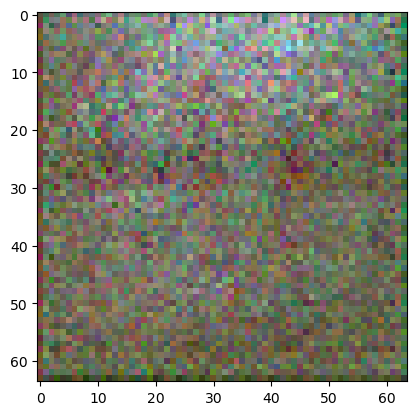

In [37]:
pic1 = model.generate(1)
pic1 = pic1.squeeze(0)
plt.imshow(pic1.permute(1, 2, 0).detach().numpy())